In [1]:
import numpy as np
import sys
from scipy.integrate import quad
sys.path.append('..')
from dcc import Parameters, AAV
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

p = Parameters()

#### Implementation using thinning
Original process collection simulation

In [2]:
def repayment_draw():
    return np.random.uniform(0.1, 1)
    
def kernel(params, t, r):
    # Return Kernel evaluation at time t
    return np.sum(np.multiply(params.delta10 + params.delta11 * r, np.exp(np.multiply(-params.kappa, t))))

def getlambda(s, arrivals, reps, params):
    # Returns lambdas(either vector or a scalar) based on a realized process history arrivals
    # arrivals[arrivals <= s] cannot have a strict inequality because of the thinning algo
    # for straight inequalities the next candidate lstar is smaller than the actual intensity at the point!
    if np.isscalar(s):
        lamb = params.lambdainf + (params.lambda0 - params.lambdainf) * np.exp(-params.kappa * s) + np.sum(kernel(params, s - arrivals[arrivals <= s], reps[arrivals <= s]))
        return lamb
    else:
        n = len(s)
        lambdas = np.zeros(n)
        for i in range(0, n):
            lambdas[i] = params.lambdainf + (params.lambda0 - params.lambdainf) * np.exp(-params.kappa * s[i]) \
                         + np.sum(kernel(params, s[i] - arrivals[arrivals <= s[i]], reps[arrivals <= s[i]]))
        return lambdas
    
def _timetransform(arrivals, repayments, params):
    thetas = np.zeros(len(arrivals) - 1)
    for i in range(1, len(arrivals)):
        thetas[i - 1] = quad(getlambda, arrivals[i - 1], arrivals[i], (arrivals, repayments, params))[0]
    return thetas
    
def modelcheck(arrivals, repayments, params):
    # fig, ax = plt.subplots()
    # res = stats.probplot(thetas, dist=stats.expon, sparams=1, fit=False, plot=sns.mpl.pyplot)
    thetas = _timetransform(arrivals, repayments, params)
    testsuit = np.random.exponential(1, len(thetas) * 2)
    _qqplot(testsuit, thetas)
    return stats.ks_2samp(testsuit, thetas)

def altmodelcheck(arrivals, repayments, params):
    residuals = _timetransform(arrivals, repayments, params)
    _, p_value = stats.kstest(residuals, 'expon', args=(0, 1))
    # _qqplot(testsuit, thetas)
    return p_value

def _qqplot(theoretical, empirical):
    # fig = plt.figure()
    percs = np.linspace(0, 100, 201)
    qn_a = np.percentile(theoretical, percs)
    qn_b = np.percentile(empirical, percs)

    plt.plot(qn_a, qn_b, ls="", marker="o")

    x = np.linspace(np.min((qn_a.min(), qn_b.min())), np.max((qn_a.max(), qn_b.max())))
    plt.plot(x, x, color="k", ls="--")

    # fig.suptitle('Q-Q plot', fontsize=20)
    plt.xlabel('Theoretical Quantiles', fontsize=18)
    plt.ylabel('Empirical Quantiles', fontsize=16)
    return plt

In [3]:
def getpath(params, horizon):
    # Simulation method based on Ogata's thinning algo
    arrivals = np.array([])
    repayments = np.array([])
    n = 0
    s = 0
    while s < horizon:
        lstar = getlambda(s, arrivals, repayments, params)
        w = -np.log(np.random.rand()) / lstar
        s = s + w
        d = np.random.rand()

        if d * lstar <= getlambda(s, arrivals, repayments, params):
            n += 1
            rep = repayment_draw()
            arrivals = np.append(arrivals, s)
            repayments = np.append(repayments, rep)
    return arrivals, repayments

In [4]:
arrivals, repayments = getpath(p, 1000)

Ks_2sampResult(statistic=0.07068062827225131, pvalue=0.5409516186757628)

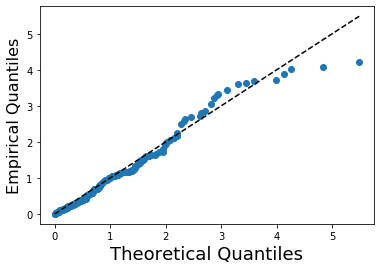

In [5]:
ms = modelcheck(arrivals, repayments, p)
ms

In [6]:
altmodelcheck(arrivals, repayments, p)

0.466982500653578

In [7]:
t_grid = np.arange(0, 1000, 0.1)

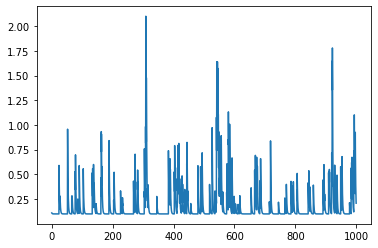

In [8]:
plt.plot(t_grid, getlambda(t_grid, arrivals, repayments, p))

In [9]:
def value_acc(w0, n=1000):
    rho = p.rho
    running_sum = 0
    vals = []
    for i in range(n):
        arrivals, repayments = getpath(p, 50)
        res = np.cumprod(1-repayments) * w0
        vals.append(np.sum(- np.diff(np.insert(res, 0, w0)) * np.exp(-rho * arrivals)))
    return vals
    

In [10]:
w = 100
mc = value_acc(w, n=1000)

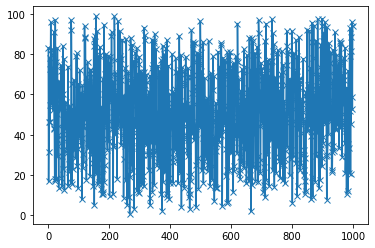

In [11]:
plt.plot(mc, marker='x')

In [12]:
np.mean(mc)

50.99447889311821

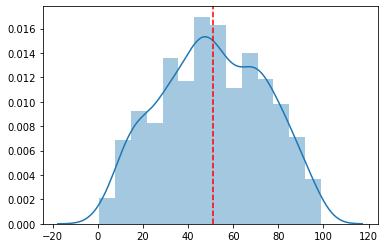

In [13]:
sns.distplot(mc)
plt.axvline(np.mean(mc), color='red', linestyle='--')

In [14]:
aav = AAV(p)

[INFO] [2020-05-21 11:16:41,524] [AAV] - Instantiated @ AAV


In [15]:
aav.u(p.lambda0, w)

-52.51486340170533

## Step by step simnulation:

In [16]:
def drift(s, lambda_start, params):
    # deterministic draft between jumps
    return params.lambdainf + (lambda_start - params.lambdainf) * np.exp(-params.kappa * s)

def simulate(params, horizon=10, dt=0.02):
    t = 0
    arrivals = []
    repayments = []
    lambdas = [params.lambda0]
    l0 = params.lambda0
    while t <= horizon:
        threshold = l0 * dt
        draw = np.random.random()
        if draw <= threshold:
            arrivals.append(t)
            r = repayment_draw()
            repayments.append(r)
            l0 = l0 + params.delta10 + params.delta11 * r
        else:
            l0 = drift(dt, l0, params)
        lambdas.append(l0)
        t += dt

    arrivals = np.array(arrivals)
    repayments = np.array(repayments)
    return arrivals, repayments, np.array(lambdas)

In [17]:
arrs, reps, lams = simulate(p, 5000, dt=0.05)

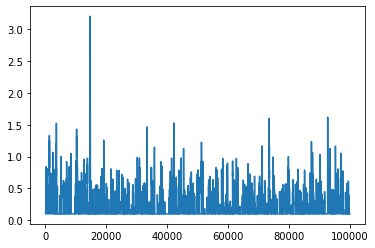

In [18]:
plt.plot(lams)

Ks_2sampResult(statistic=0.04749679075738126, pvalue=0.18990457259780613)

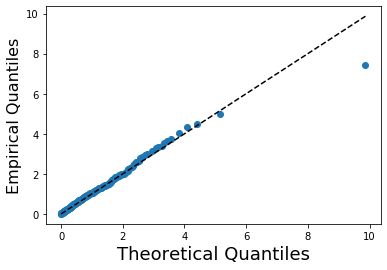

In [19]:
modelcheck(arrs, reps, p)

In [20]:
altmodelcheck(arrs, reps, p)

0.10606878459309536

In [21]:
len(arrs)

780

## Simulation from the integral

In [22]:
np.random.seed(1)
def intensity_integral(t, lambda0, params):
    # Computes the integral of the intensity function
    return params.lambdainf * t + (lambda0 - params.lambdainf) * \
           (1 - np.exp(-params.kappa * t)) / params.kappa

def simulate_from_integral(params, horizon=10, dt=0.05):
    arrivals = []
    lambdas = [params.lambda0]
    repayments = []
    l0 = params.lambda0
    t = 0
    t_from_jump = 0
    draw = np.random.exponential(1)
    while t <= horizon:
        t += dt
        t_from_jump += dt
        if intensity_integral(t_from_jump, l0, params) >= draw:
            arrivals.append(t)
            r = repayment_draw()
            repayments.append(r)
            l0 = lambdas[-1] + params.delta10 + params.delta11 * r
            lambdas.append(l0)
            draw = np.random.exponential(1)
            t_from_jump = 0
        else:
            lambdas.append(drift(t_from_jump, l0, params))

    arrivals = np.array(arrivals)
    repayments= np.array(repayments)
    return arrivals, repayments, np.array(lambdas)

def simulate_from_integral2(params, horizon=10, dt=0.05):
    arrivals = []
    lambdas = [params.lambda0]
    repayments = []
    l0 = params.lambda0
    t = 0
    t_from_jump = 0
    draw = np.random.exponential(1)
    accumulated = 0
    while t <= horizon:
        t += dt
        t_from_jump += dt
        accumulated += intensity_integral(dt, l0, params)
        if accumulated >= draw:
            accumulated = 0
            arrivals.append(t)
            r = params.sample_repayment()[0]
            repayments.append(r)
            l0 = l0 + params.delta10 + params.delta11 * r
            lambdas.append(l0)
            draw = np.random.exponential(1)
            t_from_jump = 0
        else:
#             lambdas.append(drift(t_from_jump, l0, params))
            drifted = drift(dt, lambdas[-1], params)
            l0 = drifted
            lambdas.append(drifted)

    arrivals = np.array(arrivals)
    repayments= np.array(repayments)
    return arrivals, repayments, np.array(lambdas)

In [23]:
arrsi, repayments, lamsi = simulate_from_integral2(p, horizon=10000, dt=0.05)

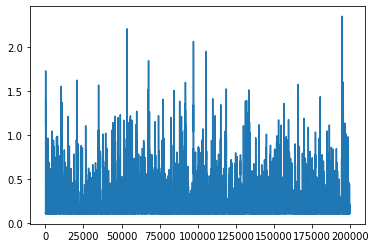

In [24]:
plt.plot(lamsi)

Ks_2sampResult(statistic=0.023262331838565024, pvalue=1.0)

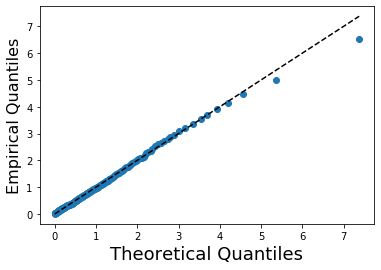

In [25]:
modelcheck(arrsi, repayments, p)

In [37]:
altmodelcheck(arrsi, repayments, p)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1775 but corresponding boolean dimension is 1785

In [27]:
def value_acc(w0, n=1000):
    rho = p.rho
    vals = []
    for i in range(n):
        arrivals, repayments, lamsi = simulate_from_integral(p, horizon=50, dt=20)
        res = np.cumprod(1-repayments) * w
        vals.append(np.sum(- np.diff(np.insert(res, 0, w)) * np.exp(-rho * arrivals)))
    return vals, arrivals, repayments
    

In [28]:
len(arrsi)

1785

## Simulate from the environment

In [38]:
from learning.collections_env.gymcollectionsenv import CollectionsEnv
env = CollectionsEnv()

In [39]:
env.dt = 0.05
env.reset()
lambdas = []
ws = []
while True:
    ob, rew, done, _ = env.step(0)
    lambdas.append(ob[0])
    ws.append(ob[1])   
#     if len(env.arrivals) >=100:
#         break
    if env.current_time >=10000:
        break
arrivals = np.array(env.arrivals)
repayments = np.array(env.repayments)

In [40]:
len(arrivals)

1723

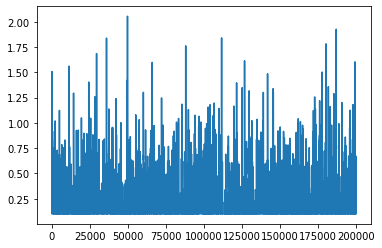

In [41]:
plt.plot(lambdas)

Ks_2sampResult(statistic=0.02061556329849013, pvalue=1.0)

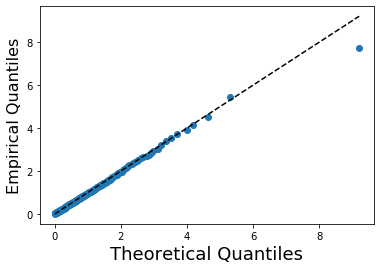

In [42]:
modelcheck(arrivals, repayments, p)

In [43]:
altmodelcheck(arrivals, repayments, p)

0.6647753432224002

Lets check the model check from the environment

In [45]:
from learning.collections_env import utils
utils.modelcheck(arrivals, repayments, p, verbose=True)

P-value: 1.0456472207974848e-82


1.0456472207974848e-82

Acc value

In [36]:
env.reset()
def single_run():
    cumrew = 0
    env.reset()
    done = False
    while not done:
        ob, rew, done, _ = env.step(1)
        cumrew +=rew
    return cumrew


In [43]:
single_run()

-31.901255373710768

In [44]:
def value_acc(w0, n=1000):
    vals = []
    for i in range(n):
        vals.append(single_run())
    return vals

In [45]:
mc = value_acc(100)

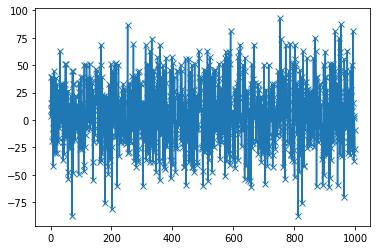

In [46]:
plt.plot(mc, marker='x')

In [138]:
np.mean(mc)

51.18678060926926

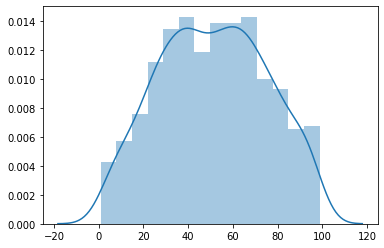

In [152]:
sns.distplot(mc)

In [208]:
intensity_integral(0.5, p.lambda0, p)

0.054218741575446955

In [261]:
length = 20
dt = 0.5
running_int = 0
l0 = p.lambda0
ls = []
for i in range(length):
    running_int += intensity_integral(0.5, l0, p)
    l0 = drift(dt, l0, p)
    ls.append(l0)
running_int

1.0142726874004921

In [262]:
intensity_integral(0.5 * length, p.lambda0, p)

1.0142726874004921

In [263]:
first = intensity_integral(0.5 * 1, p.lambda0, p)

In [264]:
second = intensity_integral(0.5 * 2, p.lambda0, p)

In [265]:
second - first

0.05297289694181863

In [266]:
intensity_integral(0.5, l0, p)

0.050003846994359995

In [281]:
dt = 20
intensity_integral(dt, p.lambda0, p) + intensity_integral(dt, drift(dt, p.lambda0, p), p)

4.0142857142857045

In [282]:
intensity_integral(2*dt, p.lambda0, p)

4.0142857142857045

In [ ]:
rep